# Training the CNN

I will train a cnn on the images of the folder Dataset, this resulting CNN will be applied to each frame of a video and will return an embedding for each frame. This will be fed into a LSTM to classify the video as either real or fake



## Image preprocessing

the images in the Dataset folder are 256x256 pixels, but the videos we are classifying with the LSTM will be preprocessed to be 64x64. For this reason, the CNN as well will be trained on images 64x64. The following code will resize the dataset and prepare the dataloader object to train the CNN


In [16]:
import torch
from torchvision.io import read_image
from torchvision.transforms.functional import resize
import os
from tqdm import tqdm

def resize_image(img_path):
    img = read_image(img_path)
    return resize(img, size = [64,64])

# testing the function
# import matplotlib.pyplot as plt
# before = read_image("Dataset/Validation/fake/fake_0.jpg")
# after = resize_image("Dataset/Validation/fake/fake_0.jpg")
# fig, axes = plt.subplots(nrows= 1, ncols= 2)
# axes = axes.flatten()
# axes[0].imshow(before.permute(1,2,0))
# axes[1].imshow(after.permute(1,2,0))

def resize_dataset(output_dir):
    for subset in ['Train', 'Validation', 'Test']:
        for class_name in ['real', 'fake']:
            input_dir = os.path.join("Dataset", subset, class_name)
            new_output_dir = os.path.join(output_dir, subset, class_name)
            os.makedirs(new_output_dir, exist_ok=True)
            
            img_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg')]
            
            for img_file in tqdm(img_files, desc=f"Processing {subset} {class_name}"):
                video_path = os.path.join(input_dir, img_file)
                processed_image = resize_image(video_path)
                
                output_path = os.path.join(new_output_dir, img_file.replace('.jpg', '.pth'))
                torch.save(processed_image, output_path)

# resize_dataset("..\\resized_images")

Processing Test fake: 100%|██████████| 5492/5492 [00:15<00:00, 355.21it/s]


## Datasets and Data loaders

In [1]:
import os
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn

IMG_DATA_BATCH_SIZE = 32
DEVICE = "cuda"
CLASS_THRESHOLD = 0.5
LR = 0.0001

class ImageDataset(Dataset):

    def __init__(self, processed_dir = "../resized_images", subset = "Train", batch_size = IMG_DATA_BATCH_SIZE, device = DEVICE):
        self.directory = processed_dir+"/"+subset
        self.batch_size = batch_size
        self.device = device
        self.images = self._get_img_paths()
        self._shuffle_data()
        self.length = int(len(self.images)/self.batch_size) + 1
    
    def _get_img_paths(self):
        imgs = []
        for img_path in os.listdir(self.directory + "/Fake"):
            imgs.append((self.directory + "/Fake/"+img_path, 1))
        for img_path in os.listdir(self.directory + "/Real"):
            imgs.append((self.directory + "/Real/"+img_path, 0))
        return imgs
    
    def _shuffle_data(self):
        np.random.shuffle(self.images)
    
    def __getitem__(self,index):
        images = []
        labels = []
        for img, label in self.images[index*self.batch_size:(index+1)*self.batch_size]:
            labels.append(label)
            images.append(torch.load(img)/256)
            x = torch.stack(images).to(self.device)
            y = torch.tensor(labels).to(self.device).to(torch.float32)
        return x, y
    
    def __len__(self):
        return self.length
    

val_img_dataset = ImageDataset(subset="Validation", batch_size= IMG_DATA_BATCH_SIZE, device = DEVICE)
train_img_dataset = ImageDataset(subset="Train", batch_size= IMG_DATA_BATCH_SIZE, device = DEVICE)

val_img_loader = DataLoader(val_img_dataset, batch_size= None, collate_fn= lambda x: x)
train_img_loader = DataLoader(train_img_dataset, batch_size= None, collate_fn= lambda x: x)

## Training function

In [2]:
def train_loop(model, epochs, train_loader, val_loader, class_threshold = CLASS_THRESHOLD):

    history = dict()

    for e in range(1,epochs+1):

        model.train()
        print("-"*40+f"|EPOCH {e}|"+"-"*40)
        losses = []
        for batch, (x,y) in tqdm(enumerate(train_loader),desc = "Training loop"):
            pred_proba, _ = model(x)
            loss_value = model.loss_function(pred_proba,y)
            losses.append(loss_value.item())
            loss_value.backward()
            model.optimizer_function.step()
            model.optimizer_function.zero_grad()
        print(f"Train Loss: {np.mean(losses):.5f} | Progress: [{batch+1}/{len(train_loader)}]")
        history[f"train_loss_epoch_{e}"] = losses
        
        model.eval()
        loss, correct, val_size = 0,0,0
        with torch.no_grad():
             for x,y in tqdm(val_loader, desc= "Validation Loop"):
                  val_size += y.shape[0]
                  pred_proba, _ = model(x)
                  loss += model.loss_function(pred_proba,y)
                  pred_class = (pred_proba > class_threshold).type(torch.float)
                  correct += (pred_class == y).type(torch.float).sum().item()
        print(f"Validation Accuracy {(correct/val_size):.2%} | Validation Loss {(loss/len(val_loader)):6f} | Train Loss {np.mean(losses):.5f}")
        history[f"val_loss_epoch_{e}"] = loss.item()
        history[f"val_correct_epoch_{e}"] = correct
        history[f"val_size_epoch_{e}"] = val_size

        train_loader.dataset._shuffle_data()
        val_loader.dataset._shuffle_data()

    for key, value in history.items():
        if isinstance(value, list):
            history[key] = np.mean(value).item()
    
    return history


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Model class

In [3]:
class DF_img_detector(nn.Module):

    def __init__(self, sequence, final_layer,
                 loss_function,
                 optimizer_constructor,
                 optimizer_kwargs = {"lr": LR}):
        super(DF_img_detector, self).__init__()
        self.sequence = sequence
        self.final_layer = final_layer
        self.loss_function = loss_function
        self.optimizer_function = optimizer_constructor(self.parameters(),**optimizer_kwargs)
        self.to(DEVICE)
    
    def forward(self, x):
        embedding = self.sequence(x)
        p_hat = self.final_layer(embedding)
        return p_hat.flatten(), embedding
    
sequence = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels= 16, kernel_size= 3, padding="valid"),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=16, out_channels= 32, kernel_size= 3, padding="valid"),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32, out_channels= 64, kernel_size= 5, padding="valid"),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Dropout(0.1)
)

final_layer = nn.Sequential(
    nn.Linear(256,1),
    nn.Sigmoid()
)

model_0 = DF_img_detector(sequence= sequence, final_layer= final_layer,
                          loss_function= nn.BCELoss(),
                          optimizer_constructor= torch.optim.Adam)

print("number of parameter: ",count_parameters(model_0))
for name, param in model_0.named_parameters():
    print(f'{name}: {param.dtype}, params: {param.numel()}')

number of parameter:  466465
sequence.0.weight: torch.float32, params: 432
sequence.0.bias: torch.float32, params: 16
sequence.4.weight: torch.float32, params: 4608
sequence.4.bias: torch.float32, params: 32
sequence.8.weight: torch.float32, params: 51200
sequence.8.bias: torch.float32, params: 64
sequence.13.weight: torch.float32, params: 409600
sequence.13.bias: torch.float32, params: 256
final_layer.0.weight: torch.float32, params: 256
final_layer.0.bias: torch.float32, params: 1


## Training the Model

In [4]:
history = train_loop(model_0, epochs= 15,
           train_loader= train_img_loader,
           val_loader=val_img_loader)
torch.save(model_0, 'pytorch models/pretrainedCNN_15_e.pth')

----------------------------------------|EPOCH 1|----------------------------------------


Training loop: 4376it [01:57, 37.10it/s]


Train Loss: 0.46408 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 39.56it/s]


Validation Accuracy 77.91% | Validation Loss 0.479638 | Train Loss 0.46408
----------------------------------------|EPOCH 2|----------------------------------------


Training loop: 4376it [01:57, 37.31it/s]


Train Loss: 0.36096 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:30<00:00, 39.86it/s]


Validation Accuracy 82.78% | Validation Loss 0.402225 | Train Loss 0.36096
----------------------------------------|EPOCH 3|----------------------------------------


Training loop: 4376it [01:59, 36.77it/s]


Train Loss: 0.30855 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:30<00:00, 41.10it/s]


Validation Accuracy 84.57% | Validation Loss 0.355804 | Train Loss 0.30855
----------------------------------------|EPOCH 4|----------------------------------------


Training loop: 4376it [01:57, 37.12it/s]


Train Loss: 0.27658 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 39.29it/s]


Validation Accuracy 85.70% | Validation Loss 0.334767 | Train Loss 0.27658
----------------------------------------|EPOCH 5|----------------------------------------


Training loop: 4376it [04:53, 14.92it/s]


Train Loss: 0.25101 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [04:57<00:00,  4.15it/s]


Validation Accuracy 86.76% | Validation Loss 0.308589 | Train Loss 0.25101
----------------------------------------|EPOCH 6|----------------------------------------


Training loop: 4376it [12:07,  6.02it/s]


Train Loss: 0.22939 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 39.57it/s]


Validation Accuracy 88.30% | Validation Loss 0.280704 | Train Loss 0.22939
----------------------------------------|EPOCH 7|----------------------------------------


Training loop: 4376it [02:01, 36.05it/s]


Train Loss: 0.21341 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:30<00:00, 40.38it/s]


Validation Accuracy 88.97% | Validation Loss 0.265870 | Train Loss 0.21341
----------------------------------------|EPOCH 8|----------------------------------------


Training loop: 4376it [01:58, 36.87it/s]


Train Loss: 0.19833 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:30<00:00, 39.88it/s]


Validation Accuracy 89.48% | Validation Loss 0.250914 | Train Loss 0.19833
----------------------------------------|EPOCH 9|----------------------------------------


Training loop: 4376it [01:59, 36.58it/s]


Train Loss: 0.18638 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 39.57it/s]


Validation Accuracy 89.07% | Validation Loss 0.256030 | Train Loss 0.18638
----------------------------------------|EPOCH 10|----------------------------------------


Training loop: 4376it [02:01, 36.00it/s]


Train Loss: 0.17684 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 38.87it/s]


Validation Accuracy 90.63% | Validation Loss 0.227131 | Train Loss 0.17684
----------------------------------------|EPOCH 11|----------------------------------------


Training loop: 4376it [01:56, 37.51it/s]


Train Loss: 0.16793 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:34<00:00, 35.32it/s]


Validation Accuracy 90.86% | Validation Loss 0.225541 | Train Loss 0.16793
----------------------------------------|EPOCH 12|----------------------------------------


Training loop: 4376it [01:57, 37.19it/s]


Train Loss: 0.15923 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 39.24it/s]


Validation Accuracy 90.60% | Validation Loss 0.225416 | Train Loss 0.15923
----------------------------------------|EPOCH 13|----------------------------------------


Training loop: 4376it [01:58, 36.90it/s]


Train Loss: 0.15366 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:31<00:00, 38.95it/s]


Validation Accuracy 90.53% | Validation Loss 0.224838 | Train Loss 0.15366
----------------------------------------|EPOCH 14|----------------------------------------


Training loop: 4376it [01:58, 36.78it/s]


Train Loss: 0.14595 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:30<00:00, 40.40it/s]


Validation Accuracy 90.42% | Validation Loss 0.227186 | Train Loss 0.14595
----------------------------------------|EPOCH 15|----------------------------------------


Training loop: 4376it [02:00, 36.46it/s]


Train Loss: 0.14019 | Progress: [4376/4376]


Validation Loop: 100%|██████████| 1233/1233 [00:30<00:00, 41.01it/s]

Validation Accuracy 91.33% | Validation Loss 0.212663 | Train Loss 0.14019


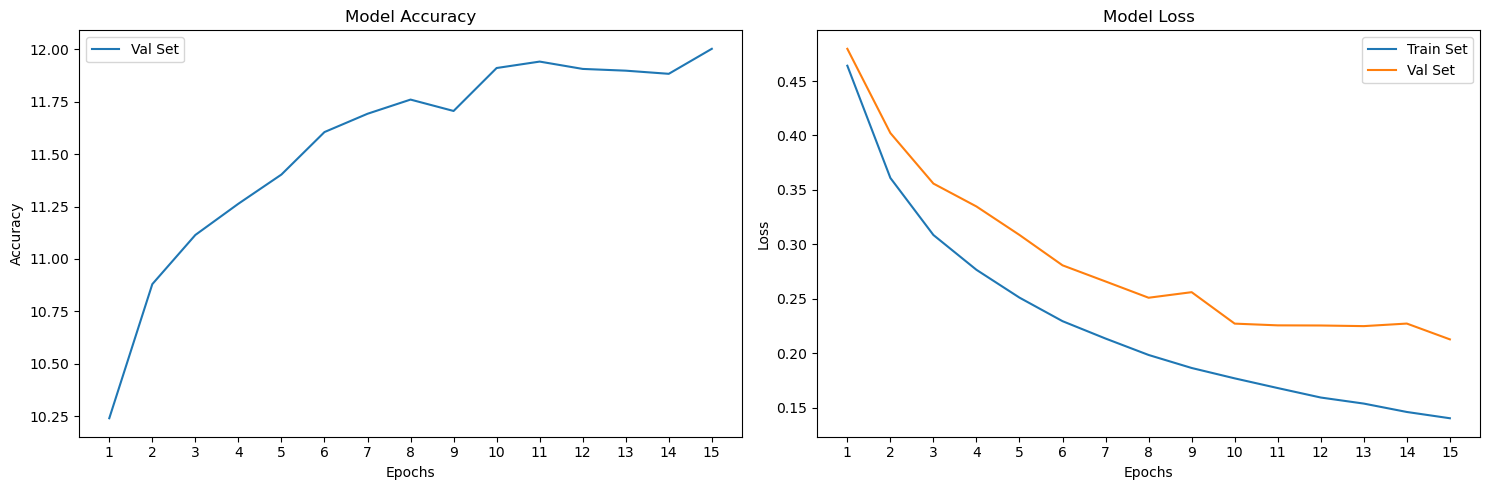

In [5]:
train_loss = []
val_accuracy = []
val_loss = []

for key, value, in history.items():
    if key.startswith("train_loss"):
        train_loss.append(value)
    if key.startswith("val_loss"):
        val_loss.append(value/len(val_img_loader))
    if key.startswith("val_correct"):
        val_accuracy.append(value/3000)

epochs = list(range(1,len(train_loss)+1))

import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.xticks(ticks=range(1, len(epochs) + 1), 
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])


# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Set')
plt.plot(epochs, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.xticks(ticks=range(1, len(epochs) + 1), 
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])

plt.tight_layout()
plt.show()

## Classification report

100%|██████████| 1233/1233 [00:31<00:00, 39.47it/s]


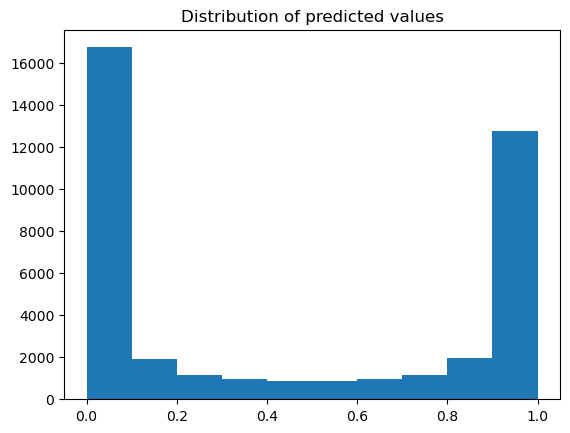

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

model_0.eval()
y_true = []
p_hats = []

with torch.no_grad():
    for x,y in tqdm(val_img_loader):
        p_hat, _ = model_0(x)
        p_hats.append(p_hat.to("cpu"))
        y_true.append(y.to("cpu"))

y_true = torch.cat(y_true).numpy()
p_hats = torch.cat(p_hats).numpy()
plt.hist(p_hats)
plt.title("Distribution of predicted values")
plt.show()

In [7]:
print(f"Validation accuracy: {accuracy_score(y_true, p_hats > 0.5)}")

print(f"Area under the curve of validation set: {roc_auc_score(y_true, p_hats)}")

print("Confusion matrix on validation set with threshold 0.5\n",confusion_matrix(y_true,  p_hats > 0.5))

print("Classification Report on validation set, t = 0.5\n",classification_report(y_true, p_hats > 0.5))

Validation accuracy: 0.9132596124581516
Area under the curve of validation set: 0.9768696693097512
Confusion matrix on validation set with threshold 0.5
 [[19024   763]
 [ 2657 16984]]
Classification Report on validation set, t = 0.5
               precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     19787
         1.0       0.96      0.86      0.91     19641

    accuracy                           0.91     39428
   macro avg       0.92      0.91      0.91     39428
weighted avg       0.92      0.91      0.91     39428



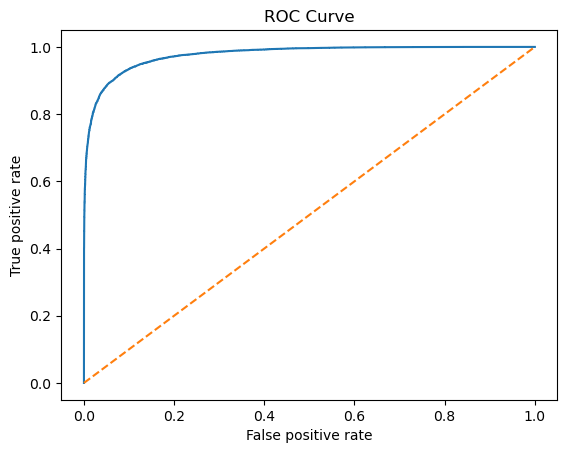

In [8]:
fpr, tpr, t = roc_curve(y_true, p_hats)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], "--")
plt.title("ROC Curve")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.show()